In [1]:
import sys
import sqlalchemy
import config
import pandas as pd
import art
import psycopg2
import jupyterlab
import ipywidgets
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
from dbcontext import Context
from jupyter_service import JupyterService
art.tprint(config.name, "big")
print(sys.version, config.version, jupyterlab.__version__, plotly.__version__, ipywidgets.__version__)

 _____   _____   _____  _____   _____ 
|_   _| / ____| / ____||  __ \ |_   _|
  | |  | (___  | |     | |__) |  | |  
  | |   \___ \ | |     |  _  /   | |  
 _| |_  ____) || |____ | | \ \  _| |_ 
|_____||_____/  \_____||_|  \_\|_____|
                                      
                                      

3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)] 0.1.0.Alpha 4.2.5 5.24.1 8.1.5


In [2]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
print(config.connection_string)
context = Context()
context.create(echo=False)
service = JupyterService(context)

postgresql://postgres:sa@localhost:5432/iscri


In [7]:
actor1_code='RUS'
actor2_code='UKR'
start_date='2022-01-01'
end_date='2024-09-30'
df = service.get_risks_by_dates_codes(start_date, end_date, actor1_code=actor1_code, actor2_code=actor2_code)
df["risk3"] = df.quad3_nb / df.total_nb
df["risk4"] = df.quad4_nb / df.total_nb
df["risk"] = df.risk3 + df.risk4
df["mobile"] = df.risk.rolling(30).mean()
df["mobile3"] = df.risk3.rolling(30).mean()
df["mobile4"] = df.risk4.rolling(30).mean()
df["conv"] = service.savgol(df.risk, 30, 3, "nearest")
df["conv3"] = service.savgol(df.risk3, 30, 3)
df["conv4"] = service.savgol(df.risk4, 30, 3)
df

SELECT * FROM daily_risk WHERE date >= '2022-01-01' AND date <= '2024-09-30' AND actor1_code = 'RUS' AND actor2_code = 'UKR'


,id,date,actor1_code,actor2_code,quad3_nb,quad4_nb,total_nb,compute_date,risk3,risk4,risk,mobile,mobile3,mobile4,conv,conv3,conv4
0,535667,2022-01-02,RUS,UKR,0.0,5.0,9.0,2024-10-20 22:41:53.667054,0.000000,0.555556,0.555556,NaN,NaN,NaN,0.485631,0.056610,0.429021
1,535739,2022-01-03,RUS,UKR,1.0,0.0,8.0,2024-10-20 22:41:53.808356,0.125000,0.000000,0.125000,NaN,NaN,NaN,0.478809,0.069078,0.409730
2,535939,2022-01-04,RUS,UKR,1.0,2.0,4.0,2024-10-20 22:41:54.010856,0.250000,0.500000,0.750000,NaN,NaN,NaN,0.467680,0.078130,0.389550
3,536113,2022-01-05,RUS,UKR,0.0,1.0,8.0,2024-10-20 22:41:54.157024,0.000000,0.125000,0.125000,NaN,NaN,NaN,0.455698,0.091835,0.363863
4,536247,2022-01-06,RUS,UKR,1.0,0.0,3.0,2024-10-20 22:41:54.307202,0.333333,0.000000,0.333333,NaN,NaN,NaN,0.441664,0.104533,0.337131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,691148,2024-09-26,RUS,UKR,9.0,5.0,43.0,2024-10-21 08:57:31.524864,0.209302,0.116279,0.325581,0.508606,0.245394,0.263212,0.512992,0.165852,0.347140
992,691321,2024-09-27,RUS,UKR,6.0,4.0,34.0,2024-10-21 08:57:31.763268,0.176471,0.117647,0.294118,0.498255,0.238873,0.259382,0.516681,0.152870,0.363811
993,691554,2024-09-28,RUS,UKR,4.0,6.0,15.0,2024-10-21 08:57:31.887365,0.266667,0.400000,0.666667,0.502830,0.243840,0.258990,0.517311,0.152624,0.364687
994,691649,2024-09-29,RUS,UKR,2.0,5.0,13.0,2024-10-21 08:57:32.028616,0.153846,0.384615,0.538462,0.505394,0.241276,0.264118,0.507184,0.145886,0.361298


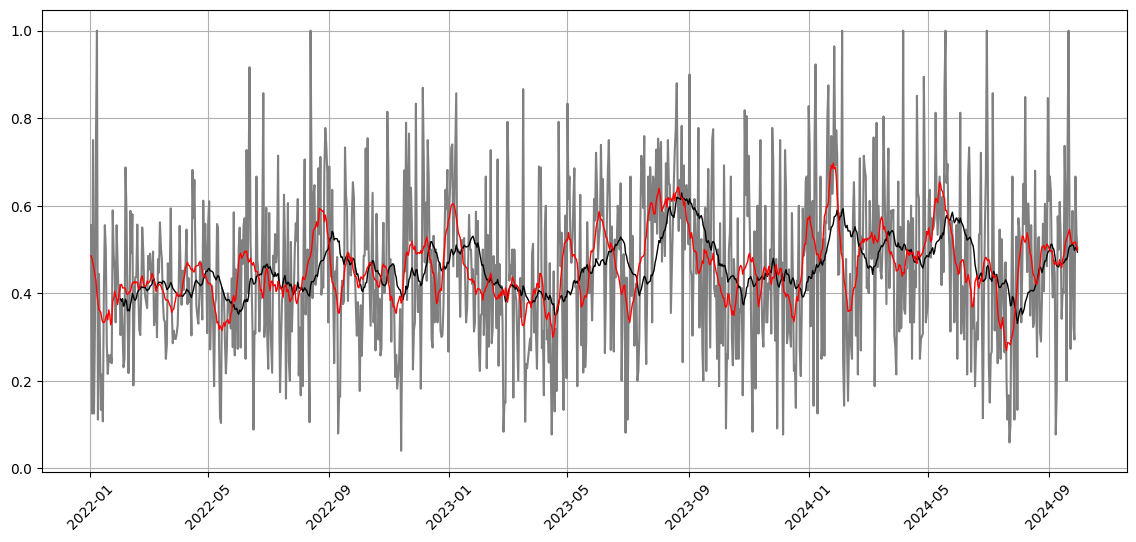

In [11]:
plt.figure(figsize=(14,6))
plt.xticks(rotation=45)
plt.grid()
plt.plot(df.date, df.risk, color="grey")
# plt.plot(df.date, df.risk4, color="red")
# plt.plot(df.date, df.risk3, color="green")
plt.plot(df.date, df.mobile, color="black", linewidth=1)
plt.plot(df.date, df.conv, color="red", linewidth=1)
plt.savefig("data/daily.png")
# plt.ylim(1.4,1.8)

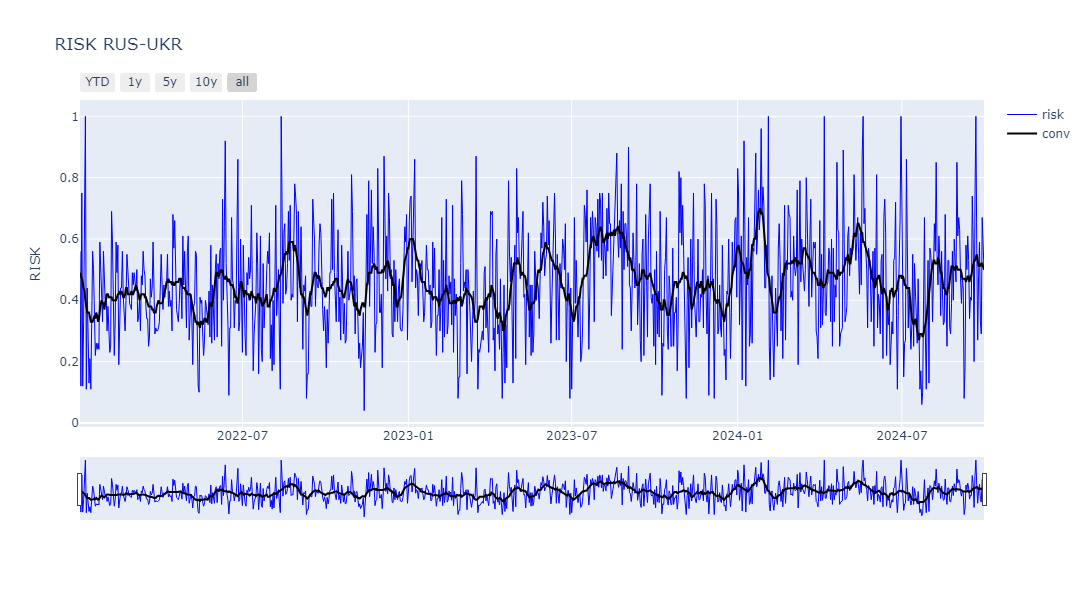

In [12]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df.date,
        y=np.round(df.risk, 2),
        name="risk",
        line=dict(color="#0000ff", width=1),
    )
)

fig.add_trace(
    go.Scatter(
        x=df.date,
        y=np.round(df.conv, 2),
        name="conv",
        line=dict(color="#000000", width=2),
    )
)

# Set title
fig.update_layout(
    height=600,
    title=f"RISK {actor1_code}-{actor2_code}",
    yaxis_title="RISK",
    xaxis=dict(tickformat="%Y-%m")
)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(count=5,
                     label="5y",
                     step="year",
                     stepmode="backward"),
                dict(count=10,
                     label="10y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ]),
            
        ),
        rangeslider=dict(
            visible=True,
        ),
        type="date"
    )
)

fig.write_html("daily.html")
fig.show()

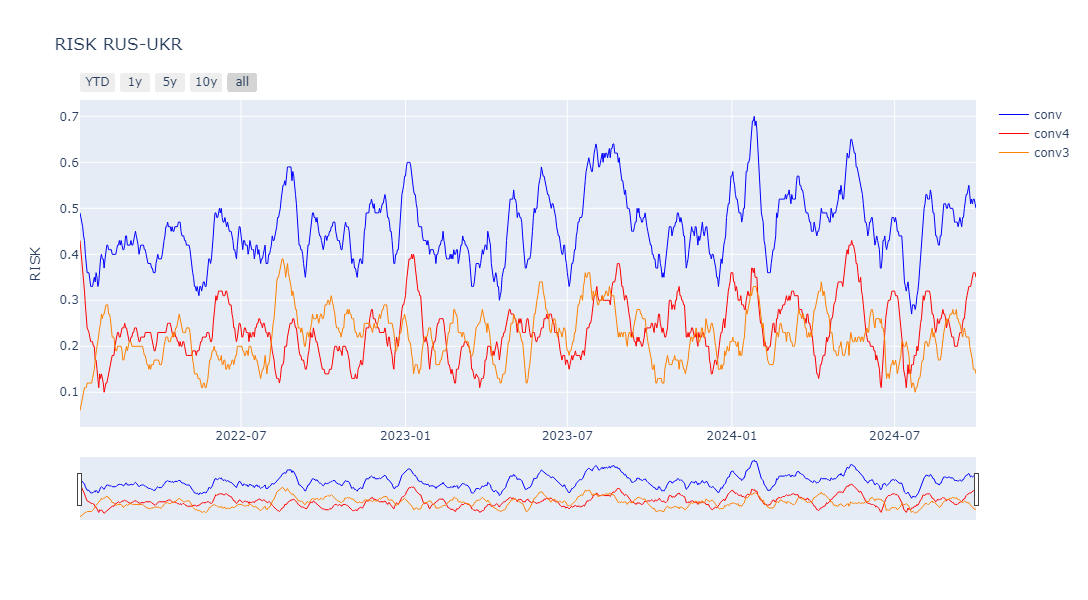

In [13]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df.date,
        y=np.round(df.conv, 2),
        name="conv",
        line=dict(color="#0000ff", width=1),
    )
)

fig.add_trace(
    go.Scatter(
        x=df.date,
        y=np.round(df.conv4, 2),
        name="conv4",
        line=dict(color="#ff0000", width=1),
    )
)

fig.add_trace(
    go.Scatter(
        x=df.date,
        y=np.round(df.conv3, 2),
        name="conv3",
        line=dict(color="#ff8000", width=1),
    )
)

# Set title
fig.update_layout(
    height=600,
    title=f"RISK {actor1_code}-{actor2_code}",
    yaxis_title="RISK",
    xaxis=dict(tickformat="%Y-%m")
)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(count=5,
                     label="5y",
                     step="year",
                     stepmode="backward"),
                dict(count=10,
                     label="10y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ]),
            
        ),
        rangeslider=dict(
            visible=True,
        ),
        type="date"
    )
)

fig.write_html("daily_x3.html")
fig.show()